# Load libraries

In [1]:
import json
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine

In [2]:
# standard
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import os
from tqdm import tqdm
import pprint # pretty printing dictionaries
import re
import os
import shutil
import joblib
import cv2
import time

# image preprocessing
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.feature import hog


# classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score


# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

# for k-fold cross-validation
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV


from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

Mounted at /content/drive
deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0  12763      0 --:--:-- --:--:-- --:--:-- 12936
OK
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 0 B of additional disk space will be used.
S

# Load data

In [3]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1723133298,"nanos":744965205},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1723133298,"nanos":745217651},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [4]:
#specify input image folder
input_path = os.path.join(local_path, 'feature_matrices')

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'weights')
os.makedirs(output_path, exist_ok=True)
os.listdir(f"{output_path}")


['grid_search_final.pkl',
 'grid_search_final_polynomial.pkl',
 'lda_best_model.pkl',
 'lda_best_model_0801.pkl',
 'lda_canny_lsqr_best_model.pkl',
 'lda_canny_lsqr_grid_search_final.pkl',
 'lda_canny_lsqr_train_score.pkl',
 'lda_cnn_lsqr_best_model.pkl',
 'lda_cnn_lsqr_grid_search_final.pkl',
 'lda_cnn_lsqr_train_score.pkl',
 'lda_grid_search_final.pkl',
 'lda_grid_search_final_0801.pkl',
 'lda_hog_eigen_best_model.pkl',
 'lda_hog_eigen_grid_search_final.pkl',
 'lda_hog_eigen_train_score.pkl',
 'lda_hog_lsqr_best_model.pkl',
 'lda_hog_lsqr_grid_search_final.pkl',
 'lda_hog_lsqr_train_score.pkl',
 'lda_hog_svd_best_model.pkl',
 'lda_hog_svd_grid_search_final.pkl',
 'lda_hog_svd_train_score.pkl',
 'lda_sift_best_model.pkl',
 'lda_sift_grid_search_final.pkl',
 'lda_sift_lsqr_best_model.pkl',
 'lda_sift_lsqr_grid_search_final.pkl',
 'lda_sift_lsqr_train_score.pkl',
 'lda_sift_train_score.pkl',
 'lda_sobel_lsqr_best_model.pkl',
 'lda_sobel_lsqr_grid_search_final.pkl',
 'lda_sobel_lsqr_trai

# Load train and validation labels

In [5]:
def load_image_labels(input_path):
    train_lb = pickle.load(open(input_path + '/' + 'train_label'  + '.pkl', 'rb'))
    val_lb = pickle.load(open(input_path + '/' + 'validation_label' + '.pkl', 'rb'))
    test_lb = pickle.load(open(input_path + '/' + 'test_label' + '.pkl', 'rb'))

    return train_lb, val_lb, test_lb

In [6]:
#load the labels from file in drive
df_train_label = load_image_labels(input_path)[0]
df_val_label = load_image_labels(input_path)[1]
df_test_label = load_image_labels(input_path)[2]


# Load Train and Validation Features

In [7]:
feature_path = os.path.join(local_path, 'features')
os.listdir(f"{feature_path}/")

['kmeans_model.pkl',
 'sift_test_features_matrix_95.pkl',
 'sift_train_features_matrix_95.pkl',
 'sift_val_features_matrix_95.pkl',
 'test_canny.pkl',
 'test_canny_pca_95.pkl',
 'test_canny_std.pkl',
 'test_cnn.pkl',
 'test_cnn_pca_95.pkl',
 'test_cnn_std.pkl',
 'test_hog.pkl',
 'test_hog_pca_95.pkl',
 'test_hog_std.pkl',
 'test_sift.pkl',
 'test_sift_pca_95.pkl',
 'test_sift_std.pkl',
 'test_sobel.pkl',
 'test_sobel_pca_95.pkl',
 'test_sobel_std.pkl',
 'tfidf_transformer.pkl',
 'train_canny.pkl',
 'train_canny_pca_95.pkl',
 'train_canny_std.pkl',
 'train_cnn.pkl',
 'train_cnn_pca_95.pkl',
 'train_cnn_std.pkl',
 'train_hog.pkl',
 'train_hog_pca_95.pkl',
 'train_hog_std.pkl',
 'train_sift.pkl',
 'train_sift_pca_95.pkl',
 'train_sift_std.pkl',
 'train_sobel.pkl',
 'train_sobel_pca_95.pkl',
 'train_sobel_std.pkl',
 'validation_canny.pkl',
 'validation_canny_pca_95.pkl',
 'validation_canny_std.pkl',
 'validation_cnn.pkl',
 'validation_cnn_pca_95.pkl',
 'validation_cnn_std.pkl',
 'validatio

In [8]:
def load_features(feature_path, feature):
    train_fm = pickle.load(open(feature_path + '/' +  'train_' + feature + '_std'  + '.pkl', 'rb'))
    val_fm = pickle.load(open(feature_path + '/' +  'validation_' + feature + '_std'  +'.pkl', 'rb'))
    test_fm = pickle.load(open(feature_path + '/' +  'test_' + feature + '_std'  + '.pkl', 'rb'))

    return train_fm, val_fm, test_fm

In [9]:
# loading feature vector for each set
x_train = load_features(feature_path,'sobel')[0]
x_val = load_features(feature_path,'sobel')[1]
x_test = load_features(feature_path,'sobel')[2]

In [10]:
# Convert to numpy arrays
x_train = np.array(list(x_train.values()))
x_val = np.array(list(x_val.values()))
x_test = np.array(list(x_test.values()))

In [11]:
x_train.shape

(6254, 27648)

In [ ]:
# get indices for feature matrices
train_fm_ind = pickle.load(open(local_path + '/features' + '/train_sobel_std'  + '.pkl', 'rb'))
val_fm_ind = pickle.load(open(local_path + '/features' + '/validation_sobel_std' + '.pkl', 'rb'))
test_fm_ind = pickle.load(open(local_path + '/features' + '/test_sobel_std' + '.pkl', 'rb'))

In [ ]:
# create dataframe with image filename as the indices
df_train = pd.DataFrame({'sobel': [pca_vector for pca_vector in x_train]}, index = list(train_fm_ind.keys()))
df_val = pd.DataFrame({'sobel': [pca_vector for pca_vector in x_val]}, index = list(val_fm_ind.keys()))
df_test = pd.DataFrame({'sobel': [pca_vector for pca_vector in x_test]}, index = list(test_fm_ind.keys()))

In [ ]:
# join feature dataframes with labels and groups on the indices
# puting df_{set}_label on the left to preserve suffled image orders
df_train = df_train_label.join(df_train, on=None, how='left', validate='one_to_one')
df_val = df_val_label.join(df_val, on=None, how='left', validate='one_to_one')
df_test = df_test_label.join(df_test, on=None, how='left', validate='one_to_one')

# Combine train and validation feature dataframes

In [ ]:
# combine train and val dataframes
df = pd.concat([df_train, df_val], axis=0)
df.head()


,label,group,sobel
image,,,
N25_100EK113_03030540.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.0494888108605687, -1...."
N25_100EK113_03030542.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.4143652002434122, -1...."
N25_100EK113_03030539.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.1757921764161683, -0...."
N25_100EK113_03030541.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -0.9512528598728799, -1...."
N25_100EK113_03030538.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.2038595909840792, -1...."


In [ ]:
df['label'].value_counts()

,count
label,
Peccary,1231
Black Agouti,1230
Dasypus Species,1229
Spotted Paca,1228
South American Coati,1117
Bos Species,1110


# ---- IF TIME ALLOWS: CHANGE LABELS OF MISLABELED IMAGES ------

In [ ]:
# mislabeled_train_images = {'N34_100EK113_01120070.JPG': 'Peccary',
#                      'N34_100EK113_01120074.JPG': 'Peccary',
#                      'N34_100EK113_01120075.JPG': 'Peccary',
#                      'A06_102EK113_07210786.JPG': 'Black agouti',
#                      'A06_102EK113_07210784.JPG':'Black agouti',
#                      'A06_102EK113_07210785.JPG': 'Black agouti'}

# Grouped k-fold cross validation for all feature vectors

- Based on https://www.linkedin.com/pulse/hyperparameter-tuning-gridsearchcv-hands-on-example-svm-dujmovic-qj3kf/
- ROC for multiclass: https://scikit-learn.org/dev/auto_examples/model_selection/plot_roc.html
- Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
X = np.vstack(df['sobel'].to_numpy())
y = df['label']
groups =  df['group']

splits = 3
model = SVC()

# parameter grid
param_grid = {
    'kernel': ['linear','rbf'],
    'decision_function_shape': ['ovr'],
    'C': [0.001, 0.5 , 1, 10, 50 ,100]
}

# grouped k-fold
gkf = GroupKFold(n_splits=splits)


grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=gkf,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

#shuffle data, using random state = 281
X, y, groups = shuffle(X, y, groups, random_state=281)

# save intermediate steps in case colab gets disconnected
intermediate_path = output_path + '/svm_sobel_grid_search_intermediate.pkl'

# Check if intermediate results exist
if os.path.exists(intermediate_path):
    saved_state = joblib.load(intermediate_path)
    grid_search = saved_state['grid_search']
    last_iteration = saved_state['last_iteration']
    print(f"Resuming grid search from iteration {last_iteration}.")
else:
    last_iteration = 0
    print("Starting new grid search.")

with tqdm(total=len(param_grid), desc="Grid Search") as pbar:
    def callback(*args, **kwargs):
        pbar.update(1)
        # Save intermediate results every 5 updates
        if pbar.n % 5 == 0:
            joblib.dump({'grid_search': grid_search, 'last_iteration': pbar.n}, intermediate_path)

    # Monkey patch the fit method to include the callback
    original_fit = grid_search.fit
    def fit_with_callback(*args, **kwargs):
        original_fit(*args, **kwargs)
        callback()

    grid_search.fit = fit_with_callback

    # Fit the model
    grid_search.fit(X, y, groups=groups)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_score = grid_search.best_score_
print("Best score found: ", best_score)

# Save the final best model
svm_best_model = grid_search.best_estimator_
pickle.dump(svm_best_model, open(output_path + '/svm_sobel_best_model.pkl', 'wb'))

joblib.dump(grid_search, output_path + '/svm_sobel_grid_search_final.pkl')





Starting new grid search.


Grid Search:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Grid Search:  33%|███▎      | 1/3 [1:17:35<2:35:11, 4655.91s/it]


Best parameters found:  {'C': 10, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
Best score found:  0.7549350776208658


['/mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/weights/svm_sobel_grid_search_final.pkl']

# Model Evaluation

In [ ]:
os.listdir(f"{output_path}")


['grid_search_final.pkl',
 'grid_search_final_polynomial.pkl',
 'lda_best_model.pkl',
 'lda_best_model_0801.pkl',
 'lda_grid_search_final.pkl',
 'lda_grid_search_final_0801.pkl',
 'svm_best_model.pkl',
 'svm_best_polynomial_model.pkl',
 'svm_hog_best_model.pkl',
 'svm_hog_grid_search_final.pkl',
 'svm_sift_best_model.pkl',
 'svm_sift_grid_search_final.pkl',
 'svm_sobel_best_model.pkl',
 'svm_sobel_grid_search_final.pkl']

In [ ]:
# load best-performing model from grid search
best_model = pickle.load(open(output_path + '/svm_sobel_best_model.pkl', 'rb'))

## Training the best model

In [ ]:
X = np.vstack(df['sobel'].to_numpy())
y = df['label']
groups = df['group']

# Shuffle data, keeping groups
X, y, groups = shuffle(X, y, groups, random_state=281)

# Initialize
splits = 3
gkf = GroupKFold(n_splits=splits)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_true = []
y_pred = []
y_scores = []
train_accuracies = []
training_times = []
incorrect_indices = []
all_predictions = np.empty_like(y_encoded)

for fold, (train_index, test_index) in enumerate(gkf.split(X, y_encoded, groups)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    start_time = time.time()

    # Fit and predict
    best_model.fit(X_train, y_train)
    y_pred_test = best_model.predict(X_test)

    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    training_times.append(training_time)

    # Get decision function scores on the test data (distance to hyperplane)
    y_score_test = best_model.decision_function(X_test)

    # Store labels
    y_true.extend(y_test)
    y_pred.extend(y_pred_test)
    y_scores.extend(y_score_test)
    all_predictions[test_index] = y_pred_test

    # Predict on training data to calculate training accuracy
    y_pred_train = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(train_accuracy)

    # Find incorrect predictions in this fold
    fold_incorrect = test_index[y_test != y_pred_test]
    incorrect_indices.extend(fold_incorrect)

    # save predictions
    all_predictions[test_index] = y_pred_test

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate the average training accuracy
average_train_accuracy = np.mean(train_accuracies)
print("Average Training Accuracy: ", average_train_accuracy)

# Calculate the average training time
average_training_time = np.mean(training_times)
print("Average Training Time: ", average_training_time, "seconds")

incorrect_indices = np.array(incorrect_indices)

# Calculate overall accuracy
mismatches = np.sum(all_predictions != y_encoded)
overall_accuracy = 1 - mismatches/len(y_encoded)
print(f"Number of mismatches: {mismatches}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Calculate accuracy from y_true and y_pred over folds
cv_accuracy = accuracy_score(y_true, y_pred)
print(f"Cross-validation Accuracy: {cv_accuracy:.4f}")

# Sanity check
assert np.isclose(overall_accuracy, cv_accuracy, atol=1e-6), "Accuracy mismatch between methods"

# add predictions to df
df_with_predictions = df.copy()
df_with_predictions['predicted_label'] = all_predictions
df_with_predictions['predicted_label_str'] = label_encoder.inverse_transform(all_predictions)


# Save the label encoder
with open('sobel_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


Average Training Accuracy:  0.9994401581506951
Average Training Time:  1100.8064006169636 seconds
Number of mismatches: 1751
Overall Accuracy: 0.7549
Cross-validation Accuracy: 0.7549


In [ ]:
# save predictions
predictions_path = os.path.join(local_path, 'predictions')
os.makedirs(predictions_path, exist_ok=True)

pickle.dump(y_pred, open(predictions_path + '/' + 'svm_sobel_y_pred' + '.pkl', 'wb'))
pickle.dump(y_scores, open(predictions_path + '/' + 'svm_sobel_y_scores' + '.pkl', 'wb'))
pickle.dump(y_true, open(predictions_path + '/' + 'svm_sobel_y_true' + '.pkl', 'wb'))

#save df_with_predictions
pickle.dump(df_with_predictions, open(predictions_path + '/' + 'svm_sobel_df_with_predictions' + '.pkl', 'wb'))

## Confusion matrix

- Percentages of each class that were correctly / incorrectly predicted.

In [ ]:
#open
# y_pred = pickle.load(open(predictions_path + '/' + 'svm_sobel_y_pred' + '.pkl', 'rb'))
# y_scores = pickle.load(open(predictions_path + '/' + 'svm_sobel_y_scores' + '.pkl', 'rb'))
# y_true = pickle.load(open(predictions_path + '/' + 'svm_sobel_y_true' + '.pkl', 'rb'))

# df_with_predictions = pickle.load(open(predictions_path + '/' + 'svm_sobel_df_with_predictions' + '.pkl', 'rb'))

## Raw numbers

<Figure size 1500x1500 with 0 Axes>

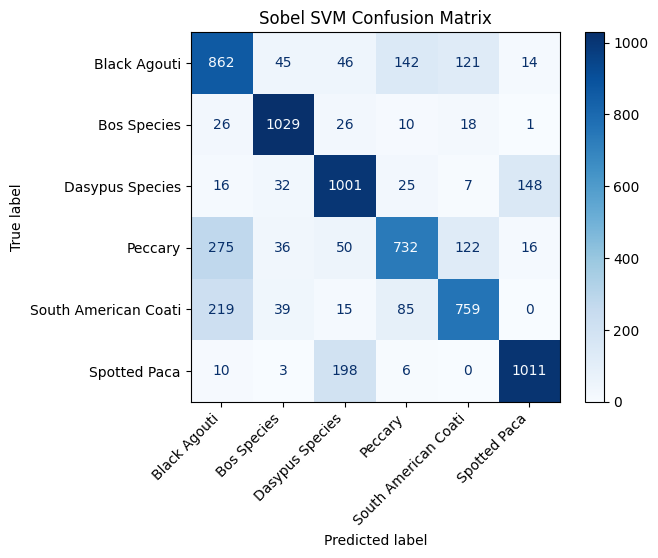

Best-performing Sobel SVM model: rbf SVM, with c = 10. Average values over K = 3 folds


In [ ]:
cm = confusion_matrix(y_true, y_pred)
label_names = label_encoder.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Sobel SVM Confusion Matrix')
plt.show()
print('Best-performing Sobel SVM model: rbf SVM, with c = 10. Average values over K = 3 folds')

## Percentages

<Figure size 1500x1500 with 0 Axes>

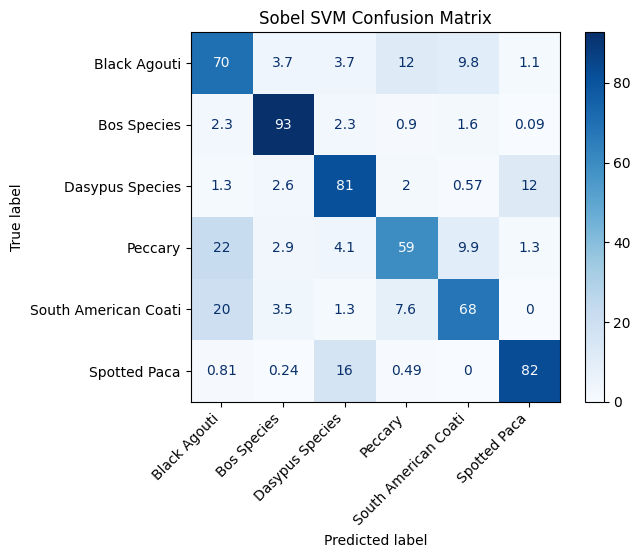

Best-performing Sobel SVM model: rbf SVM, with c = 10. Average values over K = 3 folds


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

label_names = label_encoder.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix= cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Sobel SVM Confusion Matrix')
plt.show()
print('Best-performing Sobel SVM model: rbf SVM, with c = 10. Average values over K = 3 folds')

## ROC

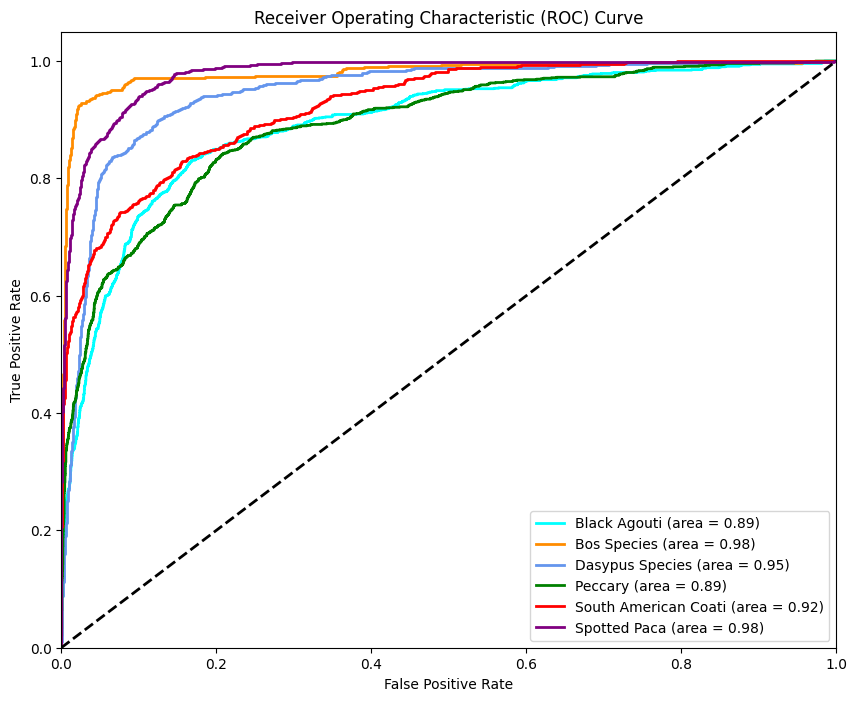

In [ ]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Gap analysis

- Where is our model stuggling?



In [ ]:
# set index as new column
df_with_predictions.reset_index(inplace=True)
df_with_predictions.head()

,image,label,group,sobel,predicted_label,predicted_label_str
0,N25_100EK113_03030540.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.0494888108605687, -1....",4,South American Coati
1,N25_100EK113_03030542.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.4143652002434122, -1....",5,Spotted Paca
2,N25_100EK113_03030539.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.1757921764161683, -0....",3,Peccary
3,N25_100EK113_03030541.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -0.9512528598728799, -1....",0,Black Agouti
4,N25_100EK113_03030538.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-1.4143652002434122, -1.2038595909840792, -1....",1,Bos Species


In [ ]:
# works, but want to add a SIFT feature, add tomorrow.
def visualize_incorrect_predictions(df, input_path_train, input_path_val, num_images=10):
    # Identify incorrect predictions
    incorrect_df = df[df['label'] != df['predicted_label_str']].copy()

    # Limit the number of images to display
    num_images = min(num_images, len(incorrect_df))

    if num_images == 0:
        print("No incorrect predictions found.")
        return

    # Select a random subset of incorrect predictions if there are more than num_images
    if len(incorrect_df) > num_images:
        incorrect_df = incorrect_df.sample(n=num_images)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, (idx, row) in enumerate(incorrect_df.iterrows()):
        # Get the image filename
        img_filename = row['image']

        # Check if the image is in the training or validation folder
        img_path_train = os.path.join(input_path_train, img_filename)
        img_path_val = os.path.join(input_path_val, img_filename)

        if os.path.exists(img_path_train):
            img_path = img_path_train
        elif os.path.exists(img_path_val):
            img_path = img_path_val
        else:
            print(f"Image not found: {img_filename}")
            continue

        # Read and display the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i].imshow(image)
        axes[i].set_title(f"True: {row['label']}\nPred: {row['predicted_label_str']}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
img_path_train = os.path.join(local_path, 'raw-data/train_data')
img_path_val = os.path.join(local_path, 'raw-data/validation_data')
input_path_preprocessed = os.path.join(local_path, 'train_data_preprocessed')

input_path_train = img_path_train
input_path_val = img_path_val

visualize_incorrect_predictions(df_with_predictions,input_path_train, input_path_val, num_images=10)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
os.listdir(local_path)

['feature_matrices',
 'features',
 'predictions',
 'raw-data',
 'test_data_preprocessed',
 'train_data_preprocessed',
 'validation_data_preprocessed',
 'weights']

## Visualize SOBEL for mispredicted images

In [ ]:
def visualize_incorrect_predictions(df, input_path_train, input_path_val, input_path_preprocessed, num_images=5):
    # Identify incorrect predictions
    incorrect_df = df[df['label'] != df['predicted_label_str']].copy()

    # Limit the number of images to display
    num_images = min(num_images, len(incorrect_df))

    if num_images == 0:
        print("No incorrect predictions found.")
        return

    # Select a random subset of incorrect predictions if there are more than num_images
    if len(incorrect_df) > num_images:
        incorrect_df = incorrect_df.sample(n=num_images)

    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5*num_images))

    for i, (idx, row) in enumerate(incorrect_df.iterrows()):
        # Get the image filename
        img_filename = row['image']

        # Check if the image is in the training or validation folder
        img_path_train = os.path.join(input_path_train, img_filename)
        img_path_val = os.path.join(input_path_val, img_filename)
        img_path_preprocessed = os.path.join(input_path_preprocessed, img_filename)

        if os.path.exists(img_path_train):
            img_path = img_path_train
        elif os.path.exists(img_path_val):
            img_path = img_path_val
        else:
            print(f"Image not found: {img_filename}")
            continue

        # Read and display the original image--------------------
        img_ori = plt.imread(img_path)
        axes[i, 0].imshow(img_ori)
        axes[i, 0].set_title(f"Original\nTrue: {row['label']}\nPred: {row['predicted_label_str']}")
        axes[i, 0].axis("off")

        # Read and preprocess the image
        img_red = plt.imread(img_path_preprocessed)
        img_gray = rgb2gray(img_red)
        img_resized = rescale(img_gray, 0.1, anti_aliasing=True)
        img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)

        # Histogram equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
        img_cl = clahe.apply(img_resized)

        #edge detection with sobel
        grad_x = cv2.Sobel(img_cl, cv2.CV_64F, 1, 0)
        grad_y = cv2.Sobel(img_cl, cv2.CV_64F, 0, 1)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

        # Display SOBEL-------------------------------------
        axes[i, 1].imshow(grad, cmap='gray', vmin=0, vmax=65)
        axes[i, 1].set_title("SOBEL")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_incorrect_predictions(df_with_predictions, input_path_train, input_path_val, input_path_preprocessed, num_images=5)

Output hidden; open in https://colab.research.google.com to view.

# Test

## Inferece

In [ ]:
# Load the label encoder
with open('sobel_label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Use best_model for inference on df_test
X_test = np.vstack(df_test['sobel'].to_numpy())
y_test = df_test['label']
groups = df_test['group']

# Print unique labels in y_test
print("Unique labels in y_test:", np.unique(y_test))

# Shuffle data, keeping groups (if necessary)
# X_test, y_test, groups = shuffle(X_test, y_test, groups, random_state=281)

# Encode the test labels using the loaded label encoder
y_encoded = label_encoder.transform(y_test)
print("Encoded labels:", y_encoded)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

y_true = []
y_pred = []
y_scores = []
incorrect_indices = []
all_predictions = np.empty_like(y_encoded)

# Predict
start_time = time.time()
y_pred_test = best_model.predict(X_test)
end_time = time.time()

# Calculate inference time
test_time = end_time - start_time

# Get decision function scores on the test data (distance to hyperplane)
y_score_test = best_model.decision_function(X_test)

# Store labels
y_true.extend(y_encoded)
y_pred.extend(y_pred_test)
y_scores.extend(y_score_test)
all_predictions[:] = y_pred_test

# Find incorrect predictions
incorrect_pred = np.where(y_encoded != y_pred_test)[0]
incorrect_indices.extend(incorrect_pred)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate the average inference time
print("Test Time: ", test_time, "seconds")

incorrect_indices = np.array(incorrect_indices)

# Calculate overall accuracy
mismatches = np.sum(all_predictions != y_encoded)
overall_accuracy = 1 - mismatches / len(y_encoded)
print(f"Number of mismatches: {mismatches}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Add predictions to df
df_test_with_predictions = df_test.copy()
df_test_with_predictions['predicted_label'] = all_predictions
df_test_with_predictions['predicted_label_str'] = label_encoder.inverse_transform(all_predictions)

Unique labels in y_test: ['Black Agouti' 'Bos Species' 'Dasypus Species' 'Peccary'
 'South American Coati' 'Spotted Paca']
Encoded labels: [3 3 3 ... 1 1 1]
Label mapping: {'Black Agouti': 0, 'Bos Species': 1, 'Dasypus Species': 2, 'Peccary': 3, 'South American Coati': 4, 'Spotted Paca': 5}
Test Time:  637.9611270427704 seconds
Number of mismatches: 465
Overall Accuracy: 0.7408


In [ ]:
y_true_test = y_true
y_pred_test = y_pred
y_scores_test = y_scores

In [ ]:
# save y_true, y_pred, y_socres and df_test_with_predictions
predictions_path = os.path.join(local_path, 'predictions')
os.makedirs(predictions_path, exist_ok=True)

pickle.dump(y_pred_test, open(predictions_path + '/' + 'svm_sobel_y_pred_test' + '.pkl', 'wb'))
pickle.dump(y_scores_test, open(predictions_path + '/' + 'svm_sobel_y_scores_test' + '.pkl', 'wb'))
pickle.dump(y_true_test, open(predictions_path + '/' + 'svm_sobel_y_true_test' + '.pkl', 'wb'))

#save df_with_predictions
pickle.dump(df_test_with_predictions, open(predictions_path + '/' + 'svm_sobel_df_test_with_predictions' + '.pkl', 'wb'))

In [ ]:
# load df_test_with_predictions, y_pre_test, y_socres_test and y_true_test
#open df_with_predictions
predictions_path = os.path.join(local_path, 'predictions')
df_test_with_predictions = pickle.load(open(predictions_path + '/' + 'svm_sobel_df_test_with_predictions' + '.pkl', 'rb'))

#open y_pred, y_true and y_scores
y_pred_test = pickle.load(open(predictions_path + '/' + 'svm_sobel_y_pred_test' + '.pkl', 'rb'))
y_scores_test = pickle.load(open(predictions_path + '/' + 'svm_sobel_y_scores_test' + '.pkl', 'rb'))
y_true_test = pickle.load(open(predictions_path + '/' + 'svm_sobel_y_true_test' + '.pkl', 'rb'))

## Confusion Matrix

<Figure size 1500x1500 with 0 Axes>

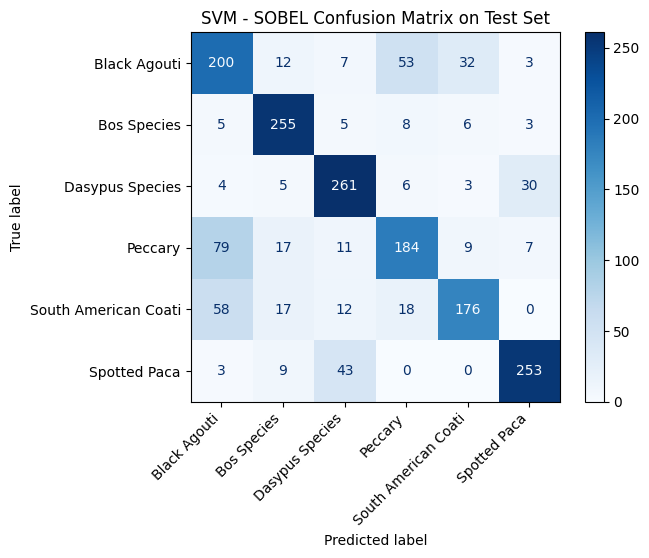

In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)
label_names = label_encoder.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('SVM - SOBEL Confusion Matrix on Test Set')
plt.show()

<Figure size 2000x2000 with 0 Axes>

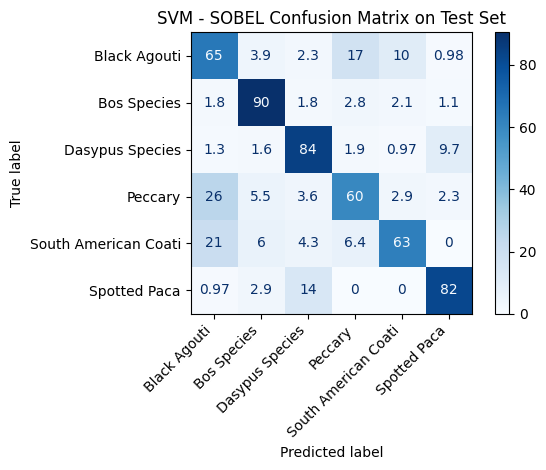

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Get the label names
label_names = label_encoder.classes_

# Create the confusion matrix plot
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('SVM - SOBEL Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

## ROC

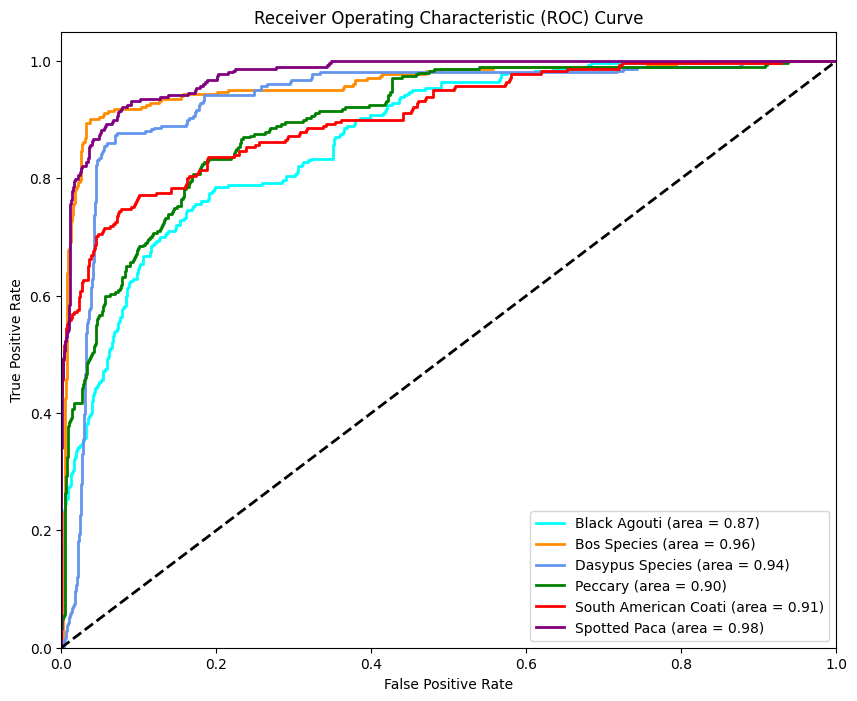

In [ ]:
# Define the order and colors for the classes
class_order = ['Black Agouti', 'Bos Species', 'Dasypus Species', 'Peccary', 'South American Coati', 'Spotted Paca']
class_colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']

# Create a mapping of class names to colors
class_color_map = {class_name: color for class_name, color in zip(class_order, class_colors)}

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_test == i, y_scores_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot the ROC curves in the specified order
for class_name in class_order:
    class_index = label_encoder.classes_.tolist().index(class_name)
    color = class_color_map[class_name]
    plt.plot(fpr[class_index], tpr[class_index], color=color, lw=2,
             label='{0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[class_index]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Gap Analysis

In [ ]:
 # set index as new column
df_test_with_predictions.reset_index(inplace=True)
df_test_with_predictions.head()

,image,label,group,sobel,predicted_label,predicted_label_str
0,N29_105EK113_04060336.JPG,Peccary,Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2,"[-1.4143652002434122, 0.031106650004006767, -1...",3,Peccary
1,N29_105EK113_04060328.JPG,Peccary,Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2,"[-1.4143652002434122, -1.0775562254284796, 0.3...",3,Peccary
2,N29_105EK113_04060331.JPG,Peccary,Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2,"[-1.4143652002434122, 0.38194933210289483, 0.3...",3,Peccary
3,N29_105EK113_04060326.JPG,Peccary,Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2,"[-1.4143652002434122, -1.035455103576613, 0.38...",3,Peccary
4,N29_105EK113_04060335.JPG,Peccary,Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2,"[-1.4143652002434122, -1.007387689008702, 0.38...",3,Peccary


In [ ]:
def visualize_incorrect_predictions(df, input_path_test, input_path_preprocessed, num_images=5):
    # Identify incorrect predictions
    incorrect_df = df[df['label'] != df['predicted_label_str']].copy()

    # Limit the number of images to display
    num_images = min(num_images, len(incorrect_df))

    if num_images == 0:
        print("No incorrect predictions found.")
        return

    # Select a random subset of incorrect predictions if there are more than num_images
    if len(incorrect_df) > num_images:
        incorrect_df = incorrect_df.sample(n=num_images)

    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5*num_images))

    for i, (idx, row) in enumerate(incorrect_df.iterrows()):
        # Get the image filename
        img_filename = row['image']

        # Check if the image is in the training or validation folder
        img_path_test = os.path.join(input_path_test, img_filename)
        img_path_preprocessed = os.path.join(input_path_preprocessed, img_filename)

        # Set the correct image path (assuming images are in the test folder)
        if os.path.exists(img_path_test):
            img_path = img_path_test
        else:
            print(f"Image not found: {img_filename}")
            continue

        # Read and display the original image--------------------
        img_ori = plt.imread(img_path) # Use the image path, not the directory path
        axes[i, 0].imshow(img_ori)
        axes[i, 0].set_title(f"Original\nTrue: {row['label']}\nPred: {row['predicted_label_str']}")
        axes[i, 0].axis("off")

        # Read and preprocess the image
        img_red = plt.imread(img_path_preprocessed)
        img_gray = rgb2gray(img_red)
        img_resized = rescale(img_gray, 0.1, anti_aliasing=True)
        img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)

        # Histogram equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
        img_cl = clahe.apply(img_resized)

        #edge detection with sobel
        grad_x = cv2.Sobel(img_cl, cv2.CV_64F, 1, 0)
        grad_y = cv2.Sobel(img_cl, cv2.CV_64F, 0, 1)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

        # Display SOBEL-------------------------------------
        axes[i, 1].imshow(grad, cmap='gray', vmin=0, vmax=65)
        axes[i, 1].set_title("SOBEL")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
img_path_test = os.path.join(local_path, 'raw-data/test_data')
input_path_preprocessed = os.path.join(local_path, 'test_data_preprocessed')

visualize_incorrect_predictions(df_test_with_predictions, input_path_preprocessed, img_path_test)

Output hidden; open in https://colab.research.google.com to view.

# Conclusions

- Sobel ha domparable results to HOG only or All features models (TrainingTest accuracies: 0.7549/0.7408), but the lowest computational performance.

- The model struggled in identifying images where there were lots of trees (to be expected, since its an edge detector).